In [1]:
from __future__ import print_function, division
import pylab as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
import statsmodels.api as sm
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Read in Data

In [2]:
if os.path.isfile(os.getenv("PUIDATA") + "/MTA_Fare.npy"):
    print("Data already there!")
else:
    os.system("curl -LJO https://raw.github.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy")
    os.system("unzip " + os.getenv("PUIDATA") + "/MTA_Fare.npy")

Data already there!


In [3]:
os.chdir(os.getenv("PUIDATA"))

In [4]:
mta = np.load("MTA_Fare.npy")

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [6]:
#ridership type list
card_types = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(card_types))

number of ride types 23


In [7]:
mta = mta.astype(float)
mta[mta < 0] = np.nan

In [8]:
#This is the information I recieved about the data: 
#"each time series (per station, per ticket type) contains the number of swipes per week 
#for 194 weeks from 05/19/2010 to 02/19/2014

weeks = pd.date_range(start='05/19/2010', periods=194, freq='W')
weeks

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

#### Plot the data in log space

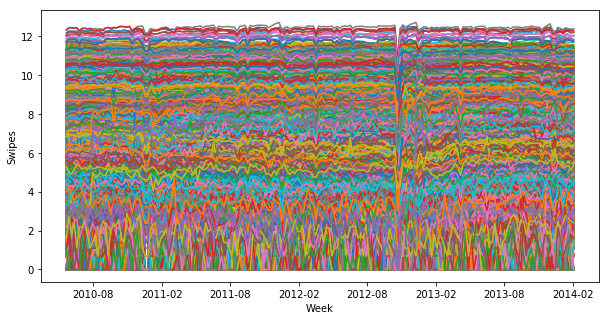

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes")
ax.set_xlabel("Week")

for station in range(np.size(mta,0)):
    for card_type in range(np.size(mta,1)):
        ax.plot(weeks, np.log(mta[station][card_type]))

Figure showing the number of swipes in log space by card type (color) and week (x-axis) over 600 MTA Subway Stations.

### Fourier Transformation

In [10]:
#sum along card axis so we have total rides per station per week for all card types
card_sum = np.nansum(mta, axis=1)

In [11]:
np.size(card_sum,0)

600

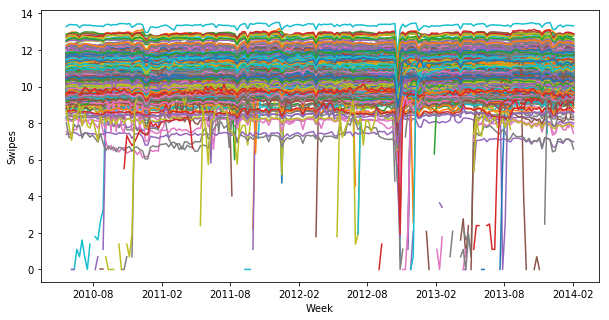

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes")
ax.set_xlabel("Week")

for station in range(np.size(card_sum,0)):
        ax.plot(weeks, np.log(card_sum[station]))

Figure showing all the number of swipes for each station over the course of 194 weeks in log space, just to take a peek at what we're looking at in terms of periodicity. 

In [13]:
N = 194
print (" The first two frequency (slowest) caculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate id every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

 The first two frequency (slowest) caculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.00515463917526 = period: every 194.0 weeks


The fastest frequency you can calculate id every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


In [14]:
f = np.abs(np.fft.rfft(card_sum, n=194))**2
freq = np.fft.rfftfreq(194, 1.0)

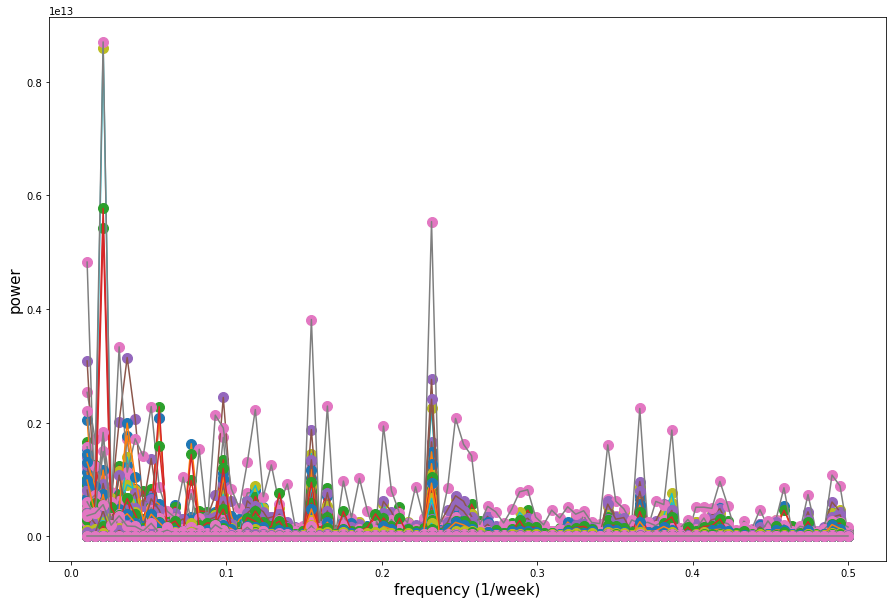

In [15]:
fig, ax = plt.subplots(figsize=(15,10))

plt.ylabel("power", fontsize=15)
plt.xlabel("frequency (1/week)", fontsize=15)

for i in range(599):
    ax.plot(freq[2:], f[i+1][2:], 'o', ms=10)
    ax.plot(freq[2:], f[i+1][2:], '-')


Figure showing the concentrated power of different periodic peaks/valleys in swipes at stations.